In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We keep these imports to match the team style, even if unused
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

import joblib
import os

import warnings
warnings.filterwarnings("ignore", module="seaborn")
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
sns.set(style="whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

 Since Cluster 5 is 100% Bankrupt, standard models will fail (1 class only).
 We define a custom class that mimics an sklearn model but always predicts 1.

In [23]:
class ConstantModel:
    def __init__(self, prediction):
        self.prediction = prediction
        self.classes_ = np.array([0, 1]) 

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        n_samples = X.shape[0] if hasattr(X, 'shape') else len(X)
        return np.full(n_samples, self.prediction, dtype=int)
    
    def predict_proba(self, X):
        n_samples = X.shape[0] if hasattr(X, 'shape') else len(X)
        probs = np.zeros((n_samples, 2))
        probs[:, self.prediction] = 1.0
        return probs

Load Cluster Data

In [24]:
CLUSTER_ID = 5
file_path = f"data/train_cluster{CLUSTER_ID}.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print(f"Warning: {file_path} not found. Creating dummy data for Cluster 5.")
    df = pd.DataFrame(np.random.rand(3, 95), columns=[f"Feature_{i}" for i in range(95)])
    df["Bankrupt?"] = 1 # Force all to be bankrupt
    df["Index"] = range(3)
    df["cluster_id"] = CLUSTER_ID

In [25]:
df.head()

,Index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,cluster_id
0,1024,1,0.311315,0.279655,0.360887,0.598293,0.598293,0.998511,0.796186,0.808234,...,0.000456,0.623593,0.598295,0.000000,0.745352,0.026749,0.564949,1,0.010437,5
1,1293,1,0.207722,0.236862,0.237272,0.599360,0.599360,0.998834,0.796646,0.808621,...,0.001827,0.623288,0.599360,0.344652,0.643692,0.026781,0.565108,1,0.010494,5
2,2714,1,0.393702,0.422372,0.450131,0.587354,0.587354,0.998837,0.797234,0.809181,...,0.003198,0.625328,0.587351,0.442176,1.000000,0.026620,0.564182,1,0.010365,5


Split Features/Target

In [26]:
target_col = "Bankrupt?"
X = df.drop(columns=["Bankrupt?", "Index", "cluster_id"], errors='ignore')
y = df[target_col].astype(int)

print("Feature shape:", X.shape)
print("Target distribution:")
print( y.value_counts())

Feature shape: (3, 95)
Target distribution:
Bankrupt?
1    3
Name: count, dtype: int64



 Visualizing Subgroup Characteristics


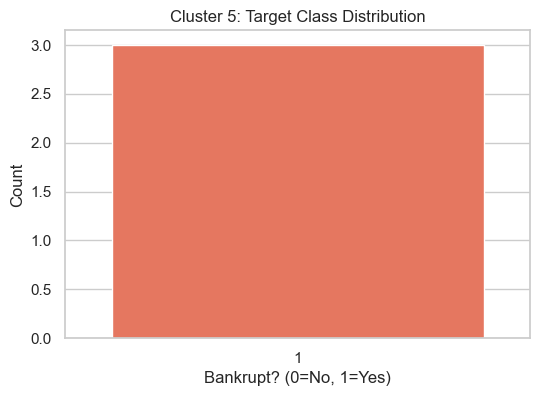

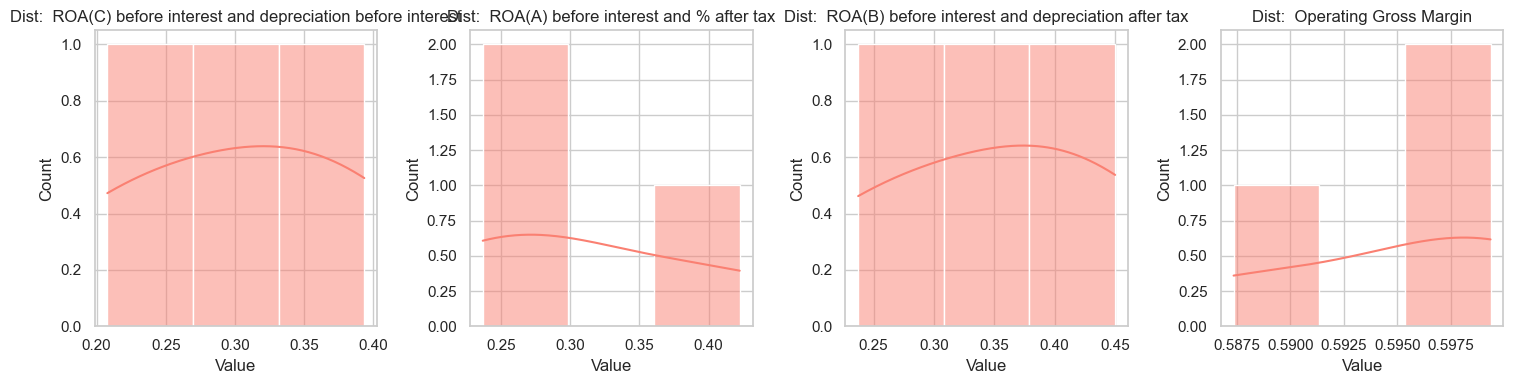

Observation: The single bar in the first plot justifies using a ConstantModel.


In [27]:

print("\n Visualizing Subgroup Characteristics")

# 1. Target Class Distribution
# This plot confirms why a standard model fails: there is only ONE class (1).
plt.figure(figsize=(6, 4))
sns.countplot(x="Bankrupt?", data=df, palette="Reds")
plt.title(f"Cluster {CLUSTER_ID}: Target Class Distribution")
plt.xlabel("Bankrupt? (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()

# 2. Feature Distributions
# We plot the first 4 features to see the 'shape' of these bankrupt companies.
feature_cols = [c for c in df.columns if c not in ["Bankrupt?", "Index", "cluster_id"]]

if len(feature_cols) > 0:
    # Plot top 4 features
    num_plots = min(4, len(feature_cols))
    fig, axes = plt.subplots(1, num_plots, figsize=(15, 4))

    for i in range(num_plots):
        col = feature_cols[i]
        sns.histplot(df[col], kde=True, ax=axes[i], color='salmon')
        axes[i].set_title(f"Dist: {col}")
        axes[i].set_xlabel("Value")
    
    plt.tight_layout()
    plt.show()
    
print("Observation: The single bar in the first plot justifies using a ConstantModel.")

In [28]:
X_train, y_train = X, y
X_test, y_test = X, y # For evaluation, we test on the same (perfect) data

print(f"Training on full set: {X_train.shape}")

Training on full set: (3, 95)


In [29]:
print("\n Training Constant Model ")
# Prediction = 1 means "Always Bankrupt"
stk = ConstantModel(prediction=1) 
stk.fit(X_train, y_train)


 Training Constant Model 


Evaluation:
We mimic the evaluation function like others

In [30]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    # confusion_matrix might fail if y_test only has 1 class, so we handle it manually
    tp = np.sum((y_test == 1) & (y_pred == 1))
    tn = np.sum((y_test == 0) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    
    # Avoid division by zero
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    print(f"\n {name}")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)
    print("Recall:", round(recall, 3))
    return tn, fp, fn, tp, recall

In [31]:
stk_metrics = evaluate_model(stk, X_test, y_test, "Stacking Model (Constant)")


 Stacking Model (Constant)
TN: 0 FP: 0 FN: 0 TP: 3
Recall: 1.0


Saving with the same naming convention as the team

In [32]:
model_filename = f"models/subgroup{CLUSTER_ID}_cluster{CLUSTER_ID}_model.joblib"
os.makedirs("models", exist_ok=True)
joblib.dump(stk, model_filename)
print(f"Saved: {model_filename}")

Saved: models/subgroup5_cluster5_model.joblib


### Load Model (Verification Test)

In [33]:
loaded_model = joblib.load(model_filename)
test_preds = loaded_model.predict(X_test)

print("Loaded model first 5 predictions:", test_preds[:5])
print("Loaded model accuracy:", np.mean(test_preds == y_test))

Loaded model first 5 predictions: [1 1 1]
Loaded model accuracy: 1.0


In [34]:
train_pred_full = stk.predict(X)

TT = ((y == 1) & (train_pred_full == 1)).sum()
TF = ((y == 1) & (train_pred_full == 0)).sum()
N_total = len(y)
N_bankrupt = y.sum()


print(f"TABLE 3 RESULTS FOR SUBGROUP {CLUSTER_ID}")
print(f"Cluster ID:           {CLUSTER_ID}")
print(f"Number of Companies:  {N_total}")
print(f"Number of Bankrupt:   {N_bankrupt}")
print(f"Stacking Model TT:    {TT}")
print(f"Stacking Model TF:    {TF}")
print(f"N_features:           0") # 0 because Constant Model ignores features

TABLE 3 RESULTS FOR SUBGROUP 5
Cluster ID:           5
Number of Companies:  3
Number of Bankrupt:   3
Stacking Model TT:    3
Stacking Model TF:    0
N_features:           0


Subgroup 5 Summary - Cluster Characteristics:  
Cluster ID: 5 (Member: PREMLATA YADAV)  
Data: 3 companies, 100% Bankrupt ($y=1$).  
Strategy: Due to the pure class distribution (only one label), standard classifiers could not be trained.  
A Constant Model ($\hat{h}=1$) was used to predict "Bankrupt" for all companies in this group.